In [1]:
import os
os.chdir("../../")

In [2]:
try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy

In [3]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

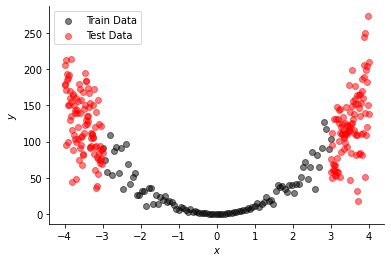

In [4]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = regression_data.data_set(n_points=100, poly=True,hetero=True)
plot.plot_actualdata(X,y,x_test_1,y_test_1,x_test_2,y_test_2)

In [5]:
data = pd.DataFrame()
data['X']  = X[:,0]
data['Y'] = y[:,0]
data = data.sort_values(by='X')
X_sorted = data['X'].values.reshape(100,1)
Y_sorted = data['Y'].values.reshape(100,1)


In [6]:
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,Y_sorted,y_test_2],axis=0)

## MLP

In [7]:
mlp_model = mlp([32, 64, 32, 1],[nn.relu]*3,[0]*3)

In [8]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [9]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [10]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.001, epochs=1000, verbose=True)

Loss step 0:  999.08075
Loss step 100:  157.45903
Loss step 200:  139.75482
Loss step 300:  120.7656
Loss step 400:  91.59877
Loss step 500:  74.001785
Loss step 600:  68.25384
Loss step 700:  65.577515
Loss step 800:  64.59457
Loss step 900:  64.041046


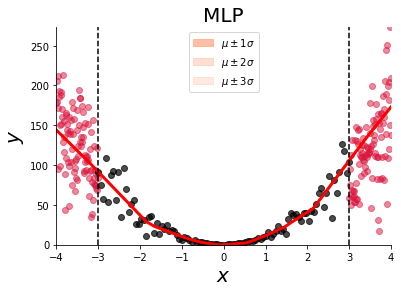

In [11]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_stack, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP')

In [13]:
def loss_calcc_mse(model,params,X,y,deterministic):
    y_hat= model.apply(params,X,deterministic=deterministic)
    loss = jnp.sum((y - y_hat)**2)/(2*X.shape[0])
    return loss
mlp_loss_test = (loss_calcc_mse(mlp_model,mlp_params,x_test_1,y_test_1,deterministic=True)+loss_calcc_mse(mlp_model,mlp_params,x_test_2,y_test_2,deterministic=True))/2
mlp_loss_train = loss_calcc_mse(mlp_model,mlp_params,X,y,deterministic=True)
mlp_loss_train,mlp_loss_test

(DeviceArray(63.70384, dtype=float32), DeviceArray(834.47076, dtype=float32))

Gaussian MLP

In [14]:
gmlp_model = gmlp(features=[128, 32], activations=[nn.relu]*2, dropout_rate=[0]*2)

In [15]:
# gmlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [16]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [17]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [18]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs, learning_rate=0.003, epochs=2000, verbose=True)

Loss step 0:  2488.72
Loss step 200:  11.6837635
Loss step 400:  6.2385254
Loss step 600:  4.983662
Loss step 800:  4.524616
Loss step 1000:  4.1171165
Loss step 1200:  3.826486
Loss step 1400:  3.6801002
Loss step 1600:  3.5358646
Loss step 1800:  3.3535995


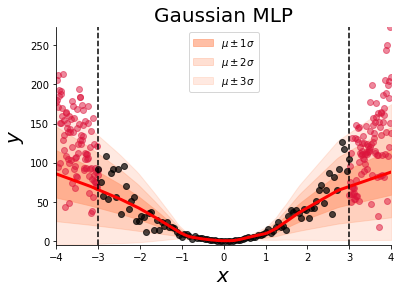

In [19]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
plot.plot_prediction(X, y, x_stack, y_stack, gmlp_mean, gmlp_sigma, "Gaussian MLP")

In [20]:
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
def loss_calcc(model,params,X,y,deterministic):
    mean,sigma = model.apply(params,X,deterministic=deterministic,rngs={"dropout": jax.random.PRNGKey(0)})
    def loss_calc(mean, sigma, y):
        d = dist.Normal(loc=mean, scale=sigma)
        return -d.prob(y)
    return jnp.mean(jax.vmap(loss_calc, in_axes=(0, 0, 0))(mean, sigma, y))
gmlp_train_loss,gmlp_test_loss= loss_calcc(gmlp_model,gmlp_params,X,y,deterministic=True),(loss_calcc(gmlp_model,gmlp_params,x_test_1,y_test_1,deterministic=True)+loss_calcc(gmlp_model,gmlp_params,x_test_1,y_test_1,deterministic=True))/2

In [21]:
gmlp_train_loss,gmlp_test_loss

(DeviceArray(-0.26268026, dtype=float32),
 DeviceArray(-0.00537676, dtype=float32))

## MC Dropout Gaussian MLP

In [22]:
mc_model = gmlp(features=[32, 64, 32], activations=[nn.elu]*3, dropout_rate=[0.01]*3)

In [23]:
mc_params = mc_model.init(jax.random.PRNGKey(0), X, True)

In [24]:
mc_params, loss = fit(mc_model, mc_params, auxs, learning_rate=0.01, epochs=1000, verbose=True)

Loss step 0:  1959.0337
Loss step 100:  4.413596
Loss step 200:  4.2411375
Loss step 300:  4.1789927
Loss step 400:  4.1210275
Loss step 500:  4.0559983
Loss step 600:  3.9724996
Loss step 700:  3.8515573
Loss step 800:  3.7300444
Loss step 900:  3.653458


In [25]:
n_stacks = 100
fn = lambda i : mc_model.apply(mc_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [26]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)

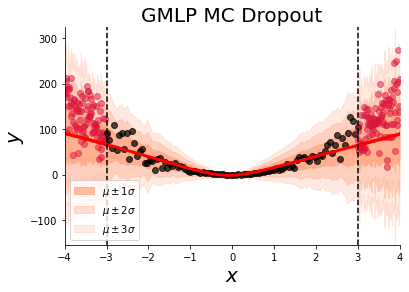

In [27]:
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

In [34]:
mc_loss_train,mc_loss_test=0,0
for i in range(n_stacks):
    mc_loss_test+=loss_calcc(gmlp_model,gmlp_params,x_test_1,y_test_1,deterministic=False)
    mc_loss_test+=loss_calcc(gmlp_model,gmlp_params,x_test_2,y_test_2,deterministic=False)
    mc_loss_train+=loss_calcc(gmlp_model,gmlp_params,X,y,deterministic=False)
mc_loss_train=mc_loss_train/100
mc_loss_test=mc_loss_test/200
mc_loss_train,mc_loss_test

(DeviceArray(-0.26268008, dtype=float32),
 DeviceArray(-0.00555425, dtype=float32))

## Deep Ensemble Gaussian MLP

In [29]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [30]:
params_list = []
losses_list = []
n_models = 3
for i in range(3):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [31]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)

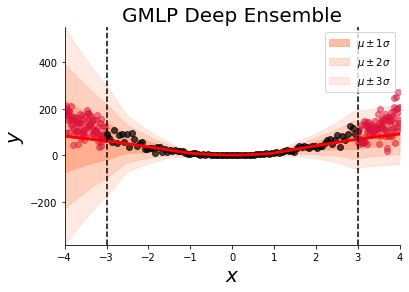

In [32]:
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

In [33]:
de_loss_train,de_loss_test=0,0
for i in range(n_models):
    de_loss_test+=loss_calcc(gmlp_model,params_list[i],x_test_1,y_test_1,deterministic=True)
    de_loss_test+=loss_calcc(gmlp_model,params_list[i],x_test_2,y_test_2,deterministic=True)
    de_loss_train+=loss_calcc(gmlp_model,params_list[i],X,y,deterministic=True)
de_loss_train = de_loss_train/n_models
de_loss_test =de_loss_test/(n_models*2)
de_loss_train,de_loss_test

(DeviceArray(-0.37535167, dtype=float32),
 DeviceArray(-0.00536172, dtype=float32))

In [35]:
key = jax.random.PRNGKey(42)
sigmaf = 5.0
len_scale =  3.0
kernel = GPy.kern.RBF(1, sigmaf, len_scale)



In [36]:
# %%capture
model_gp = GPy.models.GPRegression(X, y, kernel, normalizer=False) 
model_gp.Gaussian_noise = 1.0
model_gp.optimize(messages=True)
model_gp.optimize_restarts(num_restarts=5)



 /home/summer2022/miniconda3/envs/env-00/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 404.0568542480469
Optimization restart 2/5, f = 404.05682373046875
Optimization restart 3/5, f = 404.0567932128906
Optimization restart 4/5, f = 404.0567932128906
Optimization restart 5/5, f = 404.0567932128906


In [37]:
%%capture
mu_gp, cov_gp = model_gp.predict(x_stack)
mu_gp=mu_gp.reshape(n_points)
sigma_gp= jnp.sqrt(cov_gp).reshape(n_points)

In [38]:
mu_gp_1, cov_gp_1 = model_gp.predict(X)
mu_gp_2, cov_gp_2= model_gp.predict(x_test_1)
mu_gp_3, cov_gp_3 = model_gp.predict(x_test_2)



In [39]:
def loss_calcc3(mean,sigma,y):
    def loss_calc(mean, sigma, y):
        d = dist.Normal(loc=mean, scale=sigma)
        return -d.prob(y)
    return jnp.mean(jax.vmap(loss_calc, in_axes=(0, 0, 0))(mean, sigma, y))

In [41]:
l1 = loss_calcc3(mu_gp_1, jnp.sqrt(cov_gp_1),y)
l2 = (loss_calcc3(mu_gp_2, jnp.sqrt(cov_gp_2),y_test_1)+loss_calcc3(mu_gp_3, jnp.sqrt(cov_gp_3),y_test_2))/2
l1,l2

(DeviceArray(-0.02630634, dtype=float32),
 DeviceArray(-0.00923332, dtype=float32))

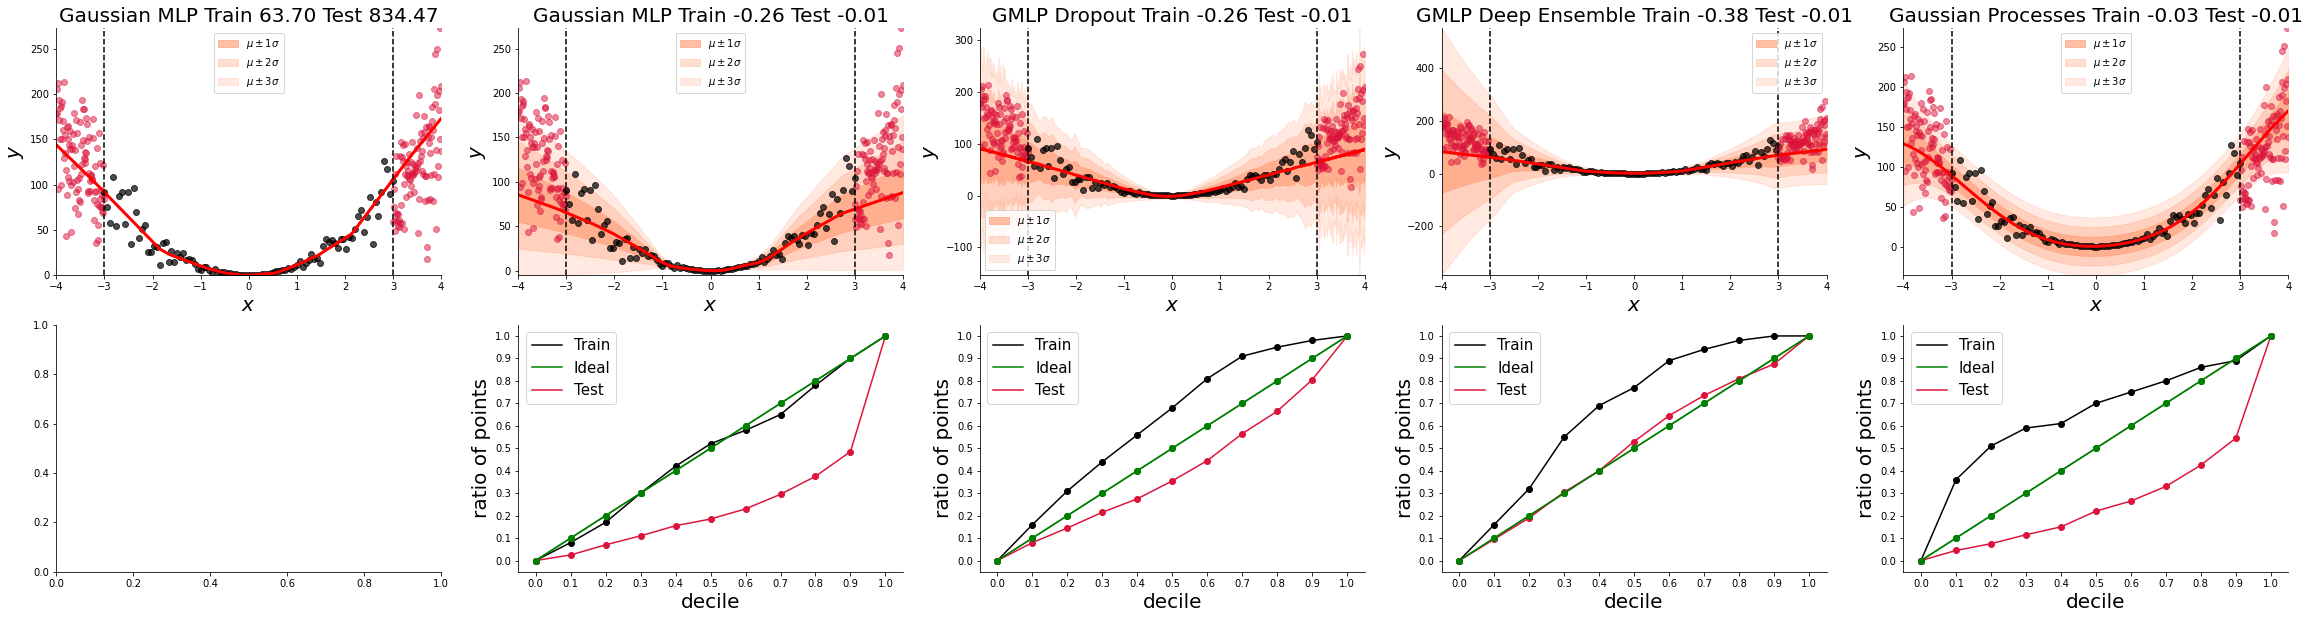

In [43]:
fig, ax = plt.subplots(2, 5, figsize=(40, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,f'Gaussian MLP Train {mlp_loss_train:.2f} Test {mlp_loss_test:.2f}',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,f'Gaussian MLP Train {gmlp_train_loss:.2f} Test {gmlp_test_loss:.2f}',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,f'GMLP Dropout Train {mc_loss_train:.2f} Test {mc_loss_test:.2f}',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,f'GMLP Deep Ensemble Train {de_loss_train:.2f} Test {de_loss_test:.2f}',ax[0][3])
plot.plot_prediction(X,y,x_stack,y_stack,mu_gp,sigma_gp,f'Gaussian Processes Train {l1:.2f} Test {l2:.2f}',ax[0][4])
# plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
plot.calibration_reg(mu_gp,sigma_gp,y_stack,ax[1][4])
plt.savefig('HeteroData.pdf')

